<a href="https://colab.research.google.com/github/luiscargarcia/PF-IABD/blob/main/Actividad_Final_PIA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESOLUCIÓN ACTIVIDAD FINAL PIA   
Nombre:

NOTA: Completa el código necesario para resolver cada uno de los apartados, incorporando el código correspondiente debajo de cada bloque de comentarios.

#### Cargar una de las imágenes histológicas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Importa las librerías necesarias
import cv2
import numpy as np
import skimage.io
from skimage import io, color, morphology, measure
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import binary_fill_holes
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, rgba2rgb
from PIL import Image, ImageCms


<ipython-input-3-cf7fab9bce1f>:7: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_fill_holes


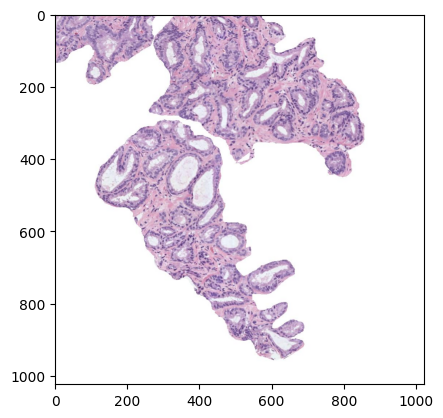

In [4]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
# Recuerda normalizar la imagen dividiéndola entre 255
image = io.imread('/content/drive/MyDrive/Colab Notebooks/histo_2.jpeg') # Reemplaza 'histo_x.jpg' con la ruta correcta
image = image / 255.0
plt.imshow(image)
plt.show()

####Define la funcion de rgb2cmyk, ya que esta viene sin definir.

In [5]:
# Define la función rgb2cmyk
def rgb2cmyk(image):
    """Convierte una imagen RGB a CMYK.

    Args:
        image: Una imagen RGB en formato numpy array.

    Returns:
        Una imagen CMYK en formato numpy array.
    """
    # Asegúrate de que la imagen esté en el rango [0, 1]
    image = np.clip(image, 0, 1)

    # Calcula los canales CMYK
    k = 1 - np.max(image, axis=2)
    c = (1 - image[..., 0] - k) / (1 - k + 1e-10)  # Maneja divisiones por cero
    m = (1 - image[..., 1] - k) / (1 - k + 1e-10)
    y = (1 - image[..., 2] - k) / (1 - k + 1e-10)

    # Apila los canales CMYK para formar la imagen CMYK
    cmyk = np.stack([c, m, y, k], axis=-1)

    return cmyk

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

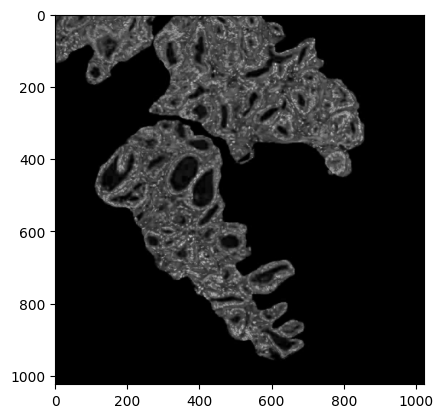

True

In [6]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)
# 2) Visualiza la imagen con la librería de matplotlib.
# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"
image_cmyk = rgb2cmyk(image) # Llama a rgb2cmyk directamente
magenta_channel = image_cmyk[:,:,1]
plt.imshow(magenta_channel, cmap='gray')
plt.show()
cv2.imwrite("1_imagen_magenta.png", (magenta_channel * 255).astype(np.uint8))

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

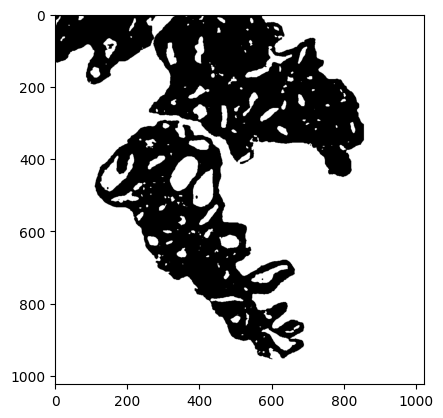

True

In [7]:
# 1) Convierte la imagen Magenta a formato "uint8"
# 2) Aplica un filtro gaussiano de tamaño 5x5
# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s.
# 5) Visualiza la máscara resultante (imagen de 0s y 1s)
# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"
magenta_uint8 = (magenta_channel * 255).astype(np.uint8)
blurred = cv2.GaussianBlur(magenta_uint8,(5,5),0)
thresh = threshold_otsu(blurred)
mask = blurred > thresh
mask = 1 - mask # Invertir para que los lúmenes sean 1s
plt.imshow(mask, cmap='gray')
plt.show()
cv2.imwrite("2_mascara_con_artefactos.png", (mask * 255).astype(np.uint8))

#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

<ipython-input-8-aedb31620529>:7: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = morphology.remove_small_objects(mask, min_size=300, connectivity=10)


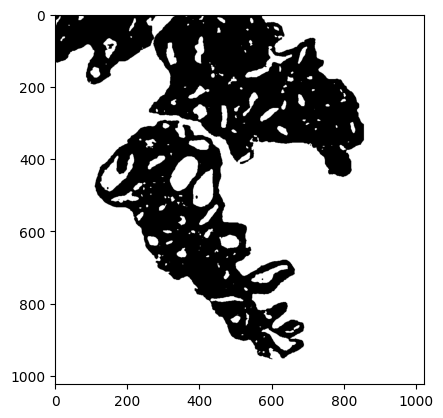

True

In [8]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects.
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
# 2) Convierte la máscara generada en formato uint8
# 3) Visualiza la máscara resultante
# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"
cleaned_mask = morphology.remove_small_objects(mask, min_size=300, connectivity=10)
cleaned_mask_uint8 = (cleaned_mask * 255).astype(np.uint8)
plt.imshow(cleaned_mask_uint8, cmap='gray')
plt.show()
cv2.imwrite("3_mascara_sin_artefactos.png", cleaned_mask_uint8)

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

<ipython-input-9-238b3a160805>:12: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_fill_holes # Importa binary_fill_holes desde el módulo correcto


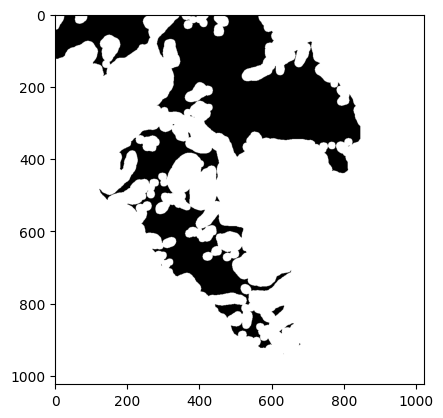

True

In [9]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
# 2) Visualiza la máscara resultante
# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"
h, w = cleaned_mask.shape
seed1 = (0,0)
seed2 = (h-1, w-1)
filled_mask = morphology.binary_dilation(cleaned_mask, footprint=morphology.disk(10)) #Ajusta el radio del disco según sea necesario
filled_mask[seed1] = 0
filled_mask[seed2] = 0
# Usa scipy.ndimage.morphology.binary_fill_holes en lugar de skimage.morphology.binary_fill_holes
from scipy.ndimage.morphology import binary_fill_holes # Importa binary_fill_holes desde el módulo correcto
filled_mask = 1 - binary_fill_holes(1-filled_mask) # Cambiado para usar binary_fill_holes de scipy.ndimage.morphology
plt.imshow(filled_mask, cmap='gray')
plt.show()
cv2.imwrite("4_mascara_lumenes.png", (filled_mask * 255).astype(np.uint8))

#### Rellenar los objetos de los lúmenes

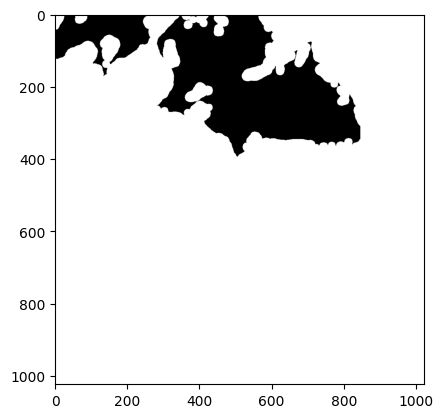

True

In [10]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
# 3) Visualiza la máscara
# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"
filled_lumens = binary_fill_holes(filled_mask)
filled_lumens_uint8 = (filled_lumens * 255).astype(np.uint8)
plt.imshow(filled_lumens_uint8, cmap='gray')
plt.show()
cv2.imwrite("5_mascara_final.png", filled_lumens_uint8)

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

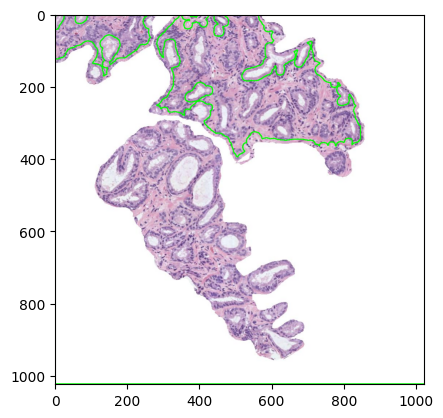

True

In [11]:
# 1) Encuentra los contornos de los lúmenes
# 2) Dibuja los contornos (de color verde) sobre la imagen original
# 3) Visualiza la imagen superpuesta
# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"
contours, _ = cv2.findContours(filled_lumens_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite("6_imagen_superpuesta.png", image_with_contours)

#### Identificar y cropear el lumen más grande

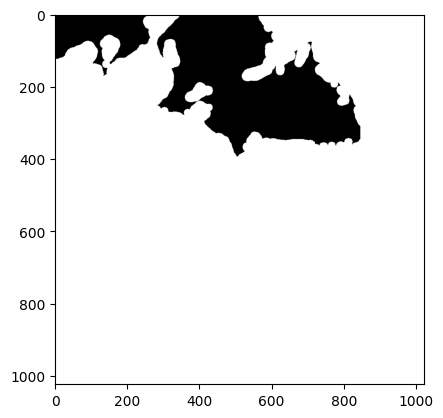

True

In [12]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
# 2) Calcula el área de cada uno de los lúmenes
# 3) Obtén una máscara del lumen de mayor área
# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
# 5) Visualiza la máscara recortada del lumen
# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"
labeled_lumens = measure.label(filled_lumens)
regions = measure.regionprops(labeled_lumens)
largest_lumen = max(regions, key=lambda region: region.area)
largest_lumen_mask = (labeled_lumens == largest_lumen.label)
minr, minc, maxr, maxc = largest_lumen.bbox
cropped_lumen = largest_lumen_mask[minr:maxr, minc:maxc]
plt.imshow(cropped_lumen, cmap='gray')
plt.show()
cv2.imwrite("7_crop_image.png", (cropped_lumen * 255).astype(np.uint8))

#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [13]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad
area = largest_lumen.area
bbox_area = largest_lumen.bbox_area
convex_area = largest_lumen.convex_area
eccentricity = largest_lumen.eccentricity
equivalent_diameter = largest_lumen.equivalent_diameter
extent = largest_lumen.extent
major_axis_length = largest_lumen.major_axis_length
minor_axis_length = largest_lumen.minor_axis_length
orientation = largest_lumen.orientation
perimeter = largest_lumen.perimeter
solidity = largest_lumen.solidity
compactness = (perimeter**2) / area
rectangularity = (4 * area) / (major_axis_length * minor_axis_length)


print(f"Área: {area:.4f}")
print(f"Área de la bounding box: {bbox_area:.4f}")
print(f"Área convexa: {convex_area:.4f}")
print(f"Excentricidad: {eccentricity:.4f}")
print(f"Diámetro equivalente: {equivalent_diameter:.4f}")
print(f"Extensión: {extent:.4f}")
print(f"Longitud del eje mayor: {major_axis_length:.4f}")
print(f"Longitud del eje menor: {minor_axis_length:.4f}")
print(f"Orientación: {orientation:.4f}")
print(f"Perímetro: {perimeter:.4f}")
print(f"Solidez: {solidity:.4f}")
print(f"Compacidad: {compactness:.4f}")
print(f"Rectangularidad: {rectangularity:.4f}")


Área: 903146.0000
Área de la bounding box: 1048576.0000
Área convexa: 1033807.0000
Excentricidad: 0.4452
Diámetro equivalente: 1072.3438
Extensión: 0.8613
Longitud del eje mayor: 1237.4949
Longitud del eje menor: 1108.0858
Orientación: -1.3215
Perímetro: 7056.2056
Solidez: 0.8736
Compacidad: 55.1296
Rectangularidad: 2.6345
